In [64]:
import re
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt


Training Data Size: 1956
Training Data Distribution:
CLASS
1    1005
0     951
Name: count, dtype: int64


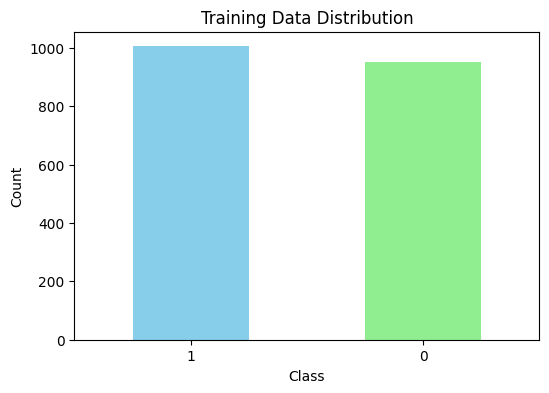

In [65]:

# Load your training dataset
file_path = '../dataset/youtube_spam.csv'
train_data = pd.read_csv(file_path)
train_texts = train_data['CONTENT']
train_labels = train_data['CLASS']

# Display training data size and distribution
print(f'Training Data Size: {len(train_data)}')
print('Training Data Distribution:')
print(train_labels.value_counts())

# Plot the distribution of classes in the training dataset
plt.figure(figsize=(6, 4))
train_labels.value_counts().plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Training Data Distribution')
plt.xticks(rotation=0)
plt.show()

# Shuffle the dataset
train_data = train_data.sample(frac=1, random_state=42)

In [66]:

def text_preprocessing(text):
    # Lowercase all sentences
    text = text.lower()
    
    # Remove numbers
    text = re.sub(r'[-+]?[0-9]+', ' ', text)
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    
    # Remove email addresses
    text = re.sub(r'\S*@\S*\s?', ' ', text)
    
    # Remove punctuation and other symbols
    text = re.sub(r'[!$%^&*@#()_+|~=`{}\[\]%\-:";\'<>?,.\/]', ' ', text)  # Tahap-5: simbol

    # Correct duplication of three or more characters in a row (e.g., "yukkk" -> "yuk")
    text = re.sub(r'([a-zA-Z])\1\1+', r'\1', text)
    
    # Remove multiple whitespace
    text = re.sub(r' +', ' ', text)
    
    # Remove leading and trailing whitespace
    text = re.sub(r'^[ ]|[ ]$', '', text)
    
    # Remove non-ASCII characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # Tokenize words
    word_tokens = word_tokenize(text)
    
    # Define Indonesian and English stopwords removal
    stop_words = set(stopwords.words('indonesian')).union(set(stopwords.words('english')))
    clean_words = [word for word in word_tokens if word not in stop_words]
    
    # Join tokens back into a clean string
    clean_words = ' '.join(clean_words)
    
    return clean_words

# Stemming and Lemmatization functions
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def stem_and_lemmatize(text):
    words = text.split()
    words = [stemmer.stem(word) for word in words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Example usage
# example_text = "Check out this amazing link: https://example.com Yukkk mariii!!! #indonesia"
# cleaned_text = text_preprocessing(example_text)
# stemmed_lemmatized_text = stem_and_lemmatize(cleaned_text)
# print(stemmed_lemmatized_text)

# Apply preprocessing to the dataset
train_texts = train_data['CONTENT'].apply(text_preprocessing).apply(stem_and_lemmatize)
train_labels = train_data['CLASS']


In [ ]:
train_texts

In [68]:
# # Define models and their hyperparameter grids for evaluation
# models = {
#     'Naive Bayes': {
#         'model': MultinomialNB(),
#         'param_grid': {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}
#     },
#     'Random Forest': {
#         'model': RandomForestClassifier(random_state=42),
#         'param_grid': {
#             'n_estimators': [50, 100, 150, 200],
#             'max_depth': [None, 10, 20, 30],
#             'min_samples_split': [2, 5, 10],
#             'min_samples_leaf': [1, 2, 4]
#         }
#     },
#     'SVM (linear kernel)': {
#         'model': SVC(kernel='linear', probability=True, random_state=42),
#         'param_grid': {'C': [0.1, 1, 10, 100]}
#     },
#     'XGBoost': {
#         'model': xgb.XGBClassifier(random_state=42),
#         'param_grid': {
#             'n_estimators': [50, 100, 150, 200],
#             'learning_rate': [0.01, 0.1, 0.2, 0.3],
#             'max_depth': [3, 5, 7, 10]
#         }
#     }
# }


In [69]:
# Define models and their hyperparameter grids for evaluation
models = {
    'RandomForest': {
        'model': RandomForestClassifier(),
        'param_grid': {
            'n_estimators': [50, 100, 150],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'NaiveBayes': {
        'model': MultinomialNB(),
        'param_grid': {
            'alpha': [0.1, 0.5, 1.0]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'param_grid': {
            'n_estimators': [50, 100, 150],
            'max_depth': [3, 6, 10],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    },
    'SVM_Linear': {
        'model': SVC(kernel='linear', probability=True),
        'param_grid': {
            'C': [0.1, 1, 10]
        }
    },
    'SVM_RBF': {
        'model': SVC(kernel='rbf', probability=True),
        'param_grid': {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto']
        }
    },
    'SVM_Poly': {
        'model': SVC(kernel='poly', probability=True),
        'param_grid': {
            'C': [0.1, 1, 10],
            'degree': [2, 3, 4]
        }
    },
    'SVM_Sigmoid': {
        'model': SVC(kernel='sigmoid', probability=True),
        'param_grid': {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto']
        }
    }
}

In [70]:
# Train and evaluate each model with different test sizes
test_sizes = [0.2, 0.25, 0.3, 0.35]
results = []



Evaluating with test size: 0.2
Balanced Training Data Size: 1600
Balanced Training Data Distribution:
{0: 800, 1: 800}


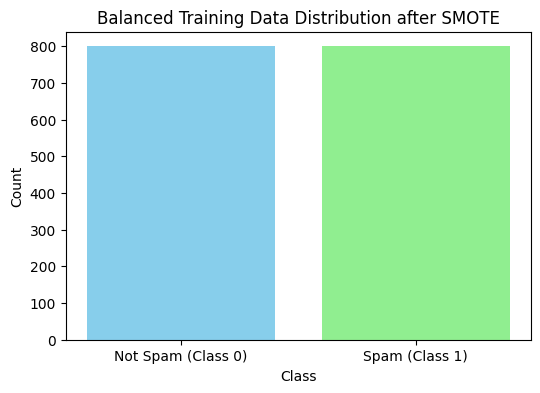


Training RandomForest with RandomizedSearchCV...
Best Parameters for RandomForest: {'n_estimators': 150, 'min_samples_split': 10, 'max_depth': None}
Best Parameters for RandomForest: {'n_estimators': 150, 'min_samples_split': 10, 'max_depth': None}
Specificity for RandomForest with test size 0.2: 0.84
Sensitivity (Recall) for RandomForest with test size 0.2: 0.94
Cross-Validation Accuracy: 0.91
Precision: 0.89
Recall: 0.89
F1 Score: 0.89

Training NaiveBayes with RandomizedSearchCV...
Best Parameters for NaiveBayes: {'alpha': 0.5}
Best Parameters for NaiveBayes: {'alpha': 0.5}
Specificity for NaiveBayes with test size 0.2: 0.92
Sensitivity (Recall) for NaiveBayes with test size 0.2: 0.89
Cross-Validation Accuracy: 0.89
Precision: 0.91
Recall: 0.91
F1 Score: 0.91

Training XGBoost with RandomizedSearchCV...


c:\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for XGBoost: {'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.2}
Best Parameters for XGBoost: {'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.2}
Specificity for XGBoost with test size 0.2: 0.97
Sensitivity (Recall) for XGBoost with test size 0.2: 0.85
Cross-Validation Accuracy: 0.92
Precision: 0.92
Recall: 0.91
F1 Score: 0.91

Training SVM_Linear with RandomizedSearchCV...


c:\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for SVM_Linear: {'C': 1}
Best Parameters for SVM_Linear: {'C': 1}
Specificity for SVM_Linear with test size 0.2: 0.96
Sensitivity (Recall) for SVM_Linear with test size 0.2: 0.89
Cross-Validation Accuracy: 0.91
Precision: 0.93
Recall: 0.92
F1 Score: 0.92

Training SVM_RBF with RandomizedSearchCV...


c:\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for SVM_RBF: {'gamma': 'scale', 'C': 10}
Best Parameters for SVM_RBF: {'gamma': 'scale', 'C': 10}
Specificity for SVM_RBF with test size 0.2: 0.93
Sensitivity (Recall) for SVM_RBF with test size 0.2: 0.91
Cross-Validation Accuracy: 0.91
Precision: 0.92
Recall: 0.92
F1 Score: 0.92

Training SVM_Poly with RandomizedSearchCV...


c:\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for SVM_Poly: {'degree': 2, 'C': 1}
Best Parameters for SVM_Poly: {'degree': 2, 'C': 1}
Specificity for SVM_Poly with test size 0.2: 0.96
Sensitivity (Recall) for SVM_Poly with test size 0.2: 0.87
Cross-Validation Accuracy: 0.90
Precision: 0.92
Recall: 0.91
F1 Score: 0.91

Training SVM_Sigmoid with RandomizedSearchCV...


c:\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for SVM_Sigmoid: {'gamma': 'scale', 'C': 1}
Best Parameters for SVM_Sigmoid: {'gamma': 'scale', 'C': 1}
Specificity for SVM_Sigmoid with test size 0.2: 0.95
Sensitivity (Recall) for SVM_Sigmoid with test size 0.2: 0.87
Cross-Validation Accuracy: 0.90
Precision: 0.91
Recall: 0.91
F1 Score: 0.91

Evaluating with test size: 0.25
Balanced Training Data Size: 1510
Balanced Training Data Distribution:
{0: 755, 1: 755}


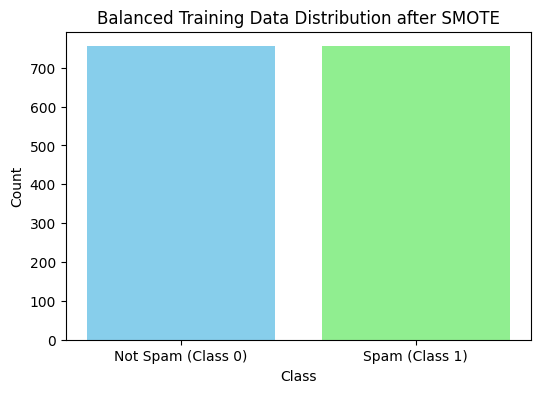


Training RandomForest with RandomizedSearchCV...
Best Parameters for RandomForest: {'n_estimators': 50, 'min_samples_split': 2, 'max_depth': None}
Best Parameters for RandomForest: {'n_estimators': 50, 'min_samples_split': 2, 'max_depth': None}
Specificity for RandomForest with test size 0.25: 0.88
Sensitivity (Recall) for RandomForest with test size 0.25: 0.93
Cross-Validation Accuracy: 0.91
Precision: 0.91
Recall: 0.91
F1 Score: 0.91

Training NaiveBayes with RandomizedSearchCV...
Best Parameters for NaiveBayes: {'alpha': 0.5}
Best Parameters for NaiveBayes: {'alpha': 0.5}
Specificity for NaiveBayes with test size 0.25: 0.90
Sensitivity (Recall) for NaiveBayes with test size 0.25: 0.90
Cross-Validation Accuracy: 0.89
Precision: 0.90
Recall: 0.90
F1 Score: 0.90

Training XGBoost with RandomizedSearchCV...


c:\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for XGBoost: {'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.2}
Best Parameters for XGBoost: {'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.2}
Specificity for XGBoost with test size 0.25: 0.98
Sensitivity (Recall) for XGBoost with test size 0.25: 0.84
Cross-Validation Accuracy: 0.92
Precision: 0.92
Recall: 0.91
F1 Score: 0.91

Training SVM_Linear with RandomizedSearchCV...


c:\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for SVM_Linear: {'C': 1}
Best Parameters for SVM_Linear: {'C': 1}
Specificity for SVM_Linear with test size 0.25: 0.96
Sensitivity (Recall) for SVM_Linear with test size 0.25: 0.89
Cross-Validation Accuracy: 0.90
Precision: 0.93
Recall: 0.93
F1 Score: 0.93

Training SVM_RBF with RandomizedSearchCV...


c:\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for SVM_RBF: {'gamma': 'scale', 'C': 1}
Best Parameters for SVM_RBF: {'gamma': 'scale', 'C': 1}
Specificity for SVM_RBF with test size 0.25: 0.98
Sensitivity (Recall) for SVM_RBF with test size 0.25: 0.88
Cross-Validation Accuracy: 0.90
Precision: 0.93
Recall: 0.93
F1 Score: 0.93

Training SVM_Poly with RandomizedSearchCV...


c:\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for SVM_Poly: {'degree': 2, 'C': 1}
Best Parameters for SVM_Poly: {'degree': 2, 'C': 1}
Specificity for SVM_Poly with test size 0.25: 0.95
Sensitivity (Recall) for SVM_Poly with test size 0.25: 0.88
Cross-Validation Accuracy: 0.89
Precision: 0.91
Recall: 0.91
F1 Score: 0.91

Training SVM_Sigmoid with RandomizedSearchCV...


c:\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for SVM_Sigmoid: {'gamma': 'scale', 'C': 1}
Best Parameters for SVM_Sigmoid: {'gamma': 'scale', 'C': 1}
Specificity for SVM_Sigmoid with test size 0.25: 0.95
Sensitivity (Recall) for SVM_Sigmoid with test size 0.25: 0.87
Cross-Validation Accuracy: 0.90
Precision: 0.91
Recall: 0.91
F1 Score: 0.91

Evaluating with test size: 0.3
Balanced Training Data Size: 1398
Balanced Training Data Distribution:
{0: 699, 1: 699}


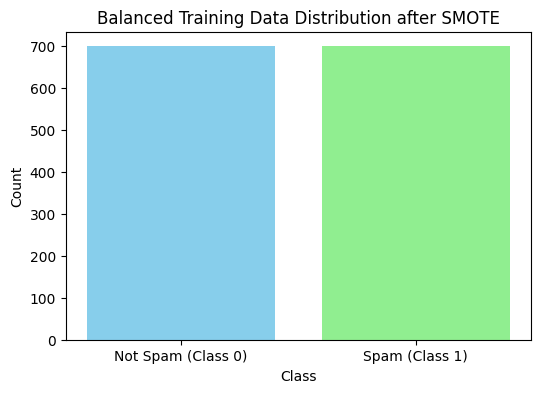


Training RandomForest with RandomizedSearchCV...
Best Parameters for RandomForest: {'n_estimators': 150, 'min_samples_split': 10, 'max_depth': None}
Best Parameters for RandomForest: {'n_estimators': 150, 'min_samples_split': 10, 'max_depth': None}
Specificity for RandomForest with test size 0.3: 0.88
Sensitivity (Recall) for RandomForest with test size 0.3: 0.93
Cross-Validation Accuracy: 0.92
Precision: 0.91
Recall: 0.91
F1 Score: 0.91

Training NaiveBayes with RandomizedSearchCV...
Best Parameters for NaiveBayes: {'alpha': 0.5}
Best Parameters for NaiveBayes: {'alpha': 0.5}
Specificity for NaiveBayes with test size 0.3: 0.90
Sensitivity (Recall) for NaiveBayes with test size 0.3: 0.88
Cross-Validation Accuracy: 0.89
Precision: 0.89
Recall: 0.89
F1 Score: 0.89

Training XGBoost with RandomizedSearchCV...


c:\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for XGBoost: {'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.2}
Best Parameters for XGBoost: {'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.2}
Specificity for XGBoost with test size 0.3: 0.98
Sensitivity (Recall) for XGBoost with test size 0.3: 0.85
Cross-Validation Accuracy: 0.92
Precision: 0.92
Recall: 0.91
F1 Score: 0.91

Training SVM_Linear with RandomizedSearchCV...


c:\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for SVM_Linear: {'C': 1}
Best Parameters for SVM_Linear: {'C': 1}
Specificity for SVM_Linear with test size 0.3: 0.96
Sensitivity (Recall) for SVM_Linear with test size 0.3: 0.88
Cross-Validation Accuracy: 0.90
Precision: 0.92
Recall: 0.92
F1 Score: 0.92

Training SVM_RBF with RandomizedSearchCV...


c:\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for SVM_RBF: {'gamma': 'scale', 'C': 10}
Best Parameters for SVM_RBF: {'gamma': 'scale', 'C': 10}
Specificity for SVM_RBF with test size 0.3: 0.94
Sensitivity (Recall) for SVM_RBF with test size 0.3: 0.91
Cross-Validation Accuracy: 0.91
Precision: 0.92
Recall: 0.92
F1 Score: 0.92

Training SVM_Poly with RandomizedSearchCV...


c:\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for SVM_Poly: {'degree': 2, 'C': 1}
Best Parameters for SVM_Poly: {'degree': 2, 'C': 1}
Specificity for SVM_Poly with test size 0.3: 0.95
Sensitivity (Recall) for SVM_Poly with test size 0.3: 0.86
Cross-Validation Accuracy: 0.89
Precision: 0.91
Recall: 0.90
F1 Score: 0.90

Training SVM_Sigmoid with RandomizedSearchCV...


c:\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for SVM_Sigmoid: {'gamma': 'scale', 'C': 1}
Best Parameters for SVM_Sigmoid: {'gamma': 'scale', 'C': 1}
Specificity for SVM_Sigmoid with test size 0.3: 0.94
Sensitivity (Recall) for SVM_Sigmoid with test size 0.3: 0.88
Cross-Validation Accuracy: 0.90
Precision: 0.91
Recall: 0.90
F1 Score: 0.90

Evaluating with test size: 0.35
Balanced Training Data Size: 1302
Balanced Training Data Distribution:
{0: 651, 1: 651}


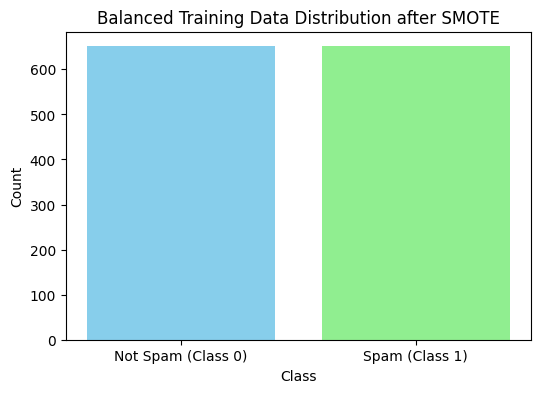


Training RandomForest with RandomizedSearchCV...
Best Parameters for RandomForest: {'n_estimators': 150, 'min_samples_split': 10, 'max_depth': None}
Best Parameters for RandomForest: {'n_estimators': 150, 'min_samples_split': 10, 'max_depth': None}
Specificity for RandomForest with test size 0.35: 0.87
Sensitivity (Recall) for RandomForest with test size 0.35: 0.94
Cross-Validation Accuracy: 0.91
Precision: 0.90
Recall: 0.90
F1 Score: 0.90

Training NaiveBayes with RandomizedSearchCV...
Best Parameters for NaiveBayes: {'alpha': 0.5}
Best Parameters for NaiveBayes: {'alpha': 0.5}
Specificity for NaiveBayes with test size 0.35: 0.89
Sensitivity (Recall) for NaiveBayes with test size 0.35: 0.88
Cross-Validation Accuracy: 0.89
Precision: 0.89
Recall: 0.88
F1 Score: 0.88

Training XGBoost with RandomizedSearchCV...


c:\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for XGBoost: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1}
Best Parameters for XGBoost: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1}
Specificity for XGBoost with test size 0.35: 0.98
Sensitivity (Recall) for XGBoost with test size 0.35: 0.83
Cross-Validation Accuracy: 0.92
Precision: 0.91
Recall: 0.90
F1 Score: 0.90

Training SVM_Linear with RandomizedSearchCV...


c:\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for SVM_Linear: {'C': 1}
Best Parameters for SVM_Linear: {'C': 1}
Specificity for SVM_Linear with test size 0.35: 0.94
Sensitivity (Recall) for SVM_Linear with test size 0.35: 0.88
Cross-Validation Accuracy: 0.90
Precision: 0.91
Recall: 0.91
F1 Score: 0.91

Training SVM_RBF with RandomizedSearchCV...


c:\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for SVM_RBF: {'gamma': 'scale', 'C': 10}
Best Parameters for SVM_RBF: {'gamma': 'scale', 'C': 10}
Specificity for SVM_RBF with test size 0.35: 0.92
Sensitivity (Recall) for SVM_RBF with test size 0.35: 0.91
Cross-Validation Accuracy: 0.90
Precision: 0.92
Recall: 0.92
F1 Score: 0.92

Training SVM_Poly with RandomizedSearchCV...


c:\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for SVM_Poly: {'degree': 2, 'C': 1}
Best Parameters for SVM_Poly: {'degree': 2, 'C': 1}
Specificity for SVM_Poly with test size 0.35: 0.94
Sensitivity (Recall) for SVM_Poly with test size 0.35: 0.86
Cross-Validation Accuracy: 0.89
Precision: 0.90
Recall: 0.89
F1 Score: 0.89

Training SVM_Sigmoid with RandomizedSearchCV...


c:\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for SVM_Sigmoid: {'gamma': 'scale', 'C': 1}
Best Parameters for SVM_Sigmoid: {'gamma': 'scale', 'C': 1}
Specificity for SVM_Sigmoid with test size 0.35: 0.93
Sensitivity (Recall) for SVM_Sigmoid with test size 0.35: 0.87
Cross-Validation Accuracy: 0.90
Precision: 0.90
Recall: 0.90
F1 Score: 0.90


In [71]:
for test_size in test_sizes:
    print(f'\nEvaluating with test size: {test_size}')

    # Split the original dataset into different training and test sets
    X_train_texts, X_test_texts, y_train, y_test = train_test_split(train_texts, train_labels, test_size=test_size, random_state=42)

    # Convert the text data into TF-IDF feature vectors
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
    X_train = tfidf_vectorizer.fit_transform(X_train_texts)
    X_test = tfidf_vectorizer.transform(X_test_texts)

    # Apply SMOTE on training data only
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Display balanced training data size and distribution
    unique, counts = np.unique(y_train, return_counts=True)
    print(f'Balanced Training Data Size: {len(y_train)}')
    print('Balanced Training Data Distribution:')
    print(dict(zip(unique, counts)))


    # Plot the distribution of classes in the balanced training dataset after SMOTE
    plt.figure(figsize=(6, 4))
    plt.bar(['Not Spam (Class 0)', 'Spam (Class 1)'], counts, color=['skyblue', 'lightgreen'])
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Balanced Training Data Distribution after SMOTE')
    plt.xticks(rotation=0)
    plt.show()

    for model_name, model_info in models.items():
        model = model_info['model']
        param_grid = model_info['param_grid']
        
        print(f'\nTraining {model_name} with RandomizedSearchCV...')
        randomized_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
        randomized_search.fit(X_train, y_train)
        
        # Get the best model from RandomizedSearchCV
        best_model = randomized_search.best_estimator_
        print(f'Best Parameters for {model_name}: {randomized_search.best_params_}')
         # Get the best model from RandomizedSearchCV
        best_model = randomized_search.best_estimator_
        best_params = randomized_search.best_params_
        print(f'Best Parameters for {model_name}: {best_params}')
        # results.append({
        #     'Model': model_name,
        #     'Test Size': test_size,
        #     'Best Parameters': best_params
        # })
        
        # Fit the best model
        # Note: The best model from RandomizedSearchCV is already fitted in randomized_search.fit(X_train, y_train)
        
        # Cross-validation on the training set
        cross_val_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
        train_accuracy = cross_val_scores.mean()
        
        # Predict using the trained model on the test set
        y_test_predictions = best_model.predict(X_test)
        y_test_probabilities = best_model.predict_proba(X_test)[:, 1]  # Probability for class 1 (Spam)

        # Save predictions to CSV file
        test_results = pd.DataFrame({
            'Text': X_test_texts,
            'Prediction': y_test_predictions,
            'Probability_Spam': y_test_probabilities
        })
        test_results['Prediction_Label'] = test_results['Prediction'].apply(lambda x: 'Spam' if x == 1 else 'Ham')
        test_results.to_csv(f'test_predictions_{model_name}_testsize_{test_size}.csv', index=False)


        # Store confusion matrices for later visualization
        conf_matrix = confusion_matrix(y_test, y_test_predictions)
        # print(f'Confusion Matrix for {model_name} with test size {test_size}:')
        # print(conf_matrix)
        # results.append({
        #     'Model': model_name,
        #     'Test Size': test_size,
        #     # 'Confusion Matrix': conf_matrix
        # })

        # Calculate confusion matrix metrics
        tn, fp, fn, tp = conf_matrix.ravel()
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
        print(f'Specificity for {model_name} with test size {test_size}: {specificity:.2f}')
        print(f'Sensitivity (Recall) for {model_name} with test size {test_size}: {sensitivity:.2f}')
        
        # Evaluate the model performance
        test_precision = precision_score(y_test, y_test_predictions, average='weighted')
        test_recall = recall_score(y_test, y_test_predictions, average='weighted')
        test_f1 = f1_score(y_test, y_test_predictions, average='weighted')
        
        results.append({
            'Model': model_name,
            'Test Size': test_size,
            'Best Parameters': best_params,
            'Accuracy': train_accuracy,
            'Precision': test_precision,
            'Recall': test_recall,
            'F1 Score': test_f1
        })
        
        print(f'Cross-Validation Accuracy: {train_accuracy:.2f}')
        print(f'Precision: {test_precision:.2f}')
        print(f'Recall: {test_recall:.2f}')
        print(f'F1 Score: {test_f1:.2f}')

In [72]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Save results to an Excel or CSV file
results_df.to_excel('model_evaluation_results.xlsx', index=False)
results_df.to_csv('model_evaluation_results.csv', index=False)


           Model  Test Size  \
0   RandomForest       0.20   
1     NaiveBayes       0.20   
2        XGBoost       0.20   
3     SVM_Linear       0.20   
4        SVM_RBF       0.20   
5       SVM_Poly       0.20   
6    SVM_Sigmoid       0.20   
7   RandomForest       0.25   
8     NaiveBayes       0.25   
9        XGBoost       0.25   
10    SVM_Linear       0.25   
11       SVM_RBF       0.25   
12      SVM_Poly       0.25   
13   SVM_Sigmoid       0.25   
14  RandomForest       0.30   
15    NaiveBayes       0.30   
16       XGBoost       0.30   
17    SVM_Linear       0.30   
18       SVM_RBF       0.30   
19      SVM_Poly       0.30   
20   SVM_Sigmoid       0.30   
21  RandomForest       0.35   
22    NaiveBayes       0.35   
23       XGBoost       0.35   
24    SVM_Linear       0.35   
25       SVM_RBF       0.35   
26      SVM_Poly       0.35   
27   SVM_Sigmoid       0.35   

                                      Best Parameters  Accuracy  Precision  \
0   {'n_estimators': 1

In [73]:
# Find the best performing model for each metric
best_accuracy_model = results_df.loc[results_df['Accuracy'].idxmax()]
best_precision_model = results_df.loc[results_df['Precision'].idxmax()]
best_recall_model = results_df.loc[results_df['Recall'].idxmax()]
best_f1_model = results_df.loc[results_df['F1 Score'].idxmax()]

print("Best Model based on Accuracy:")
print(best_accuracy_model)

print("\nBest Model based on Precision:")
print(best_precision_model)

print("\nBest Model based on Recall:")
print(best_recall_model)

print("\nBest Model based on F1 Score:")
print(best_f1_model)

Best Model based on Accuracy:
Model                                                   RandomForest
Test Size                                                        0.3
Best Parameters    {'n_estimators': 150, 'min_samples_split': 10,...
Accuracy                                                    0.923438
Precision                                                   0.908754
Recall                                                      0.908007
F1 Score                                                     0.90786
Name: 14, dtype: object

Best Model based on Precision:
Model                                 SVM_RBF
Test Size                                0.25
Best Parameters    {'gamma': 'scale', 'C': 1}
Accuracy                             0.898013
Precision                            0.934796
Recall                                0.93047
F1 Score                              0.93038
Name: 11, dtype: object

Best Model based on Recall:
Model                                 SVM_RBF
Test Size 

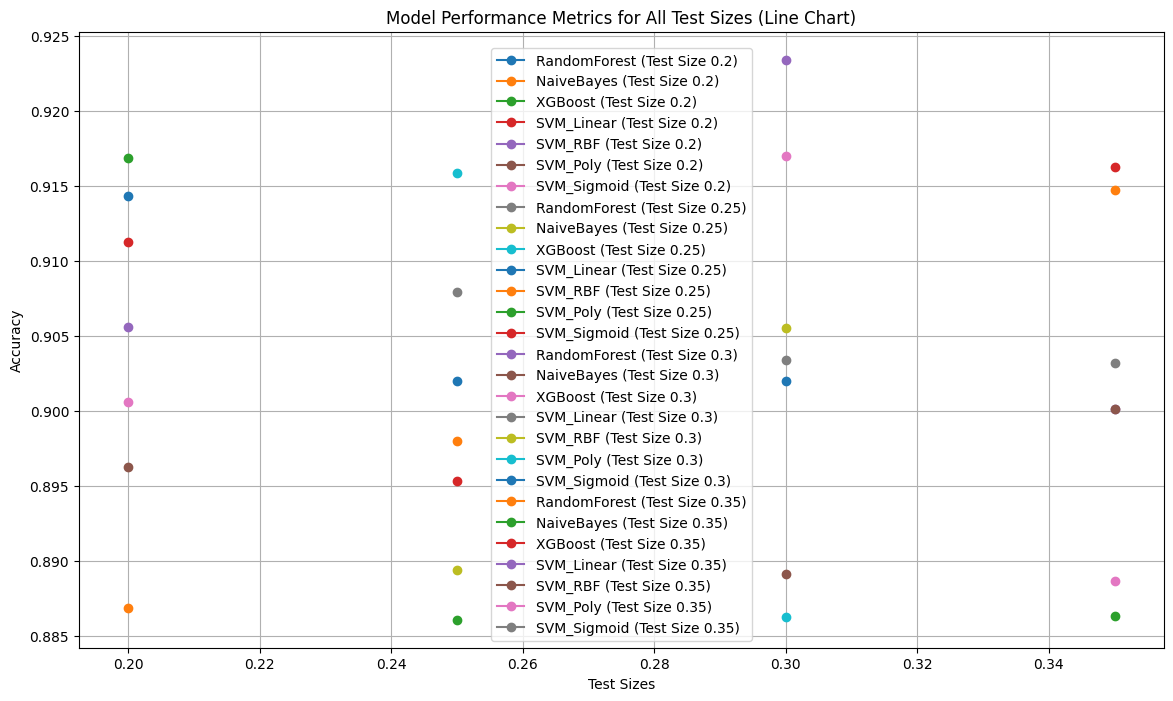

In [74]:
# Visualization of the comparison using line chart for all test sizes
plt.figure(figsize=(14, 8))
for test_size in test_sizes:
    filtered_results = results_df[results_df['Test Size'] == test_size]
    for model_name in filtered_results['Model'].unique():
        model_results = filtered_results[filtered_results['Model'] == model_name]
        plt.plot(model_results['Test Size'], model_results['Accuracy'], marker='o', label=f'{model_name} (Test Size {test_size})')

plt.xlabel('Test Sizes')
plt.ylabel('Accuracy')
plt.title('Model Performance Metrics for All Test Sizes (Line Chart)')
plt.legend()
plt.grid()
plt.show()


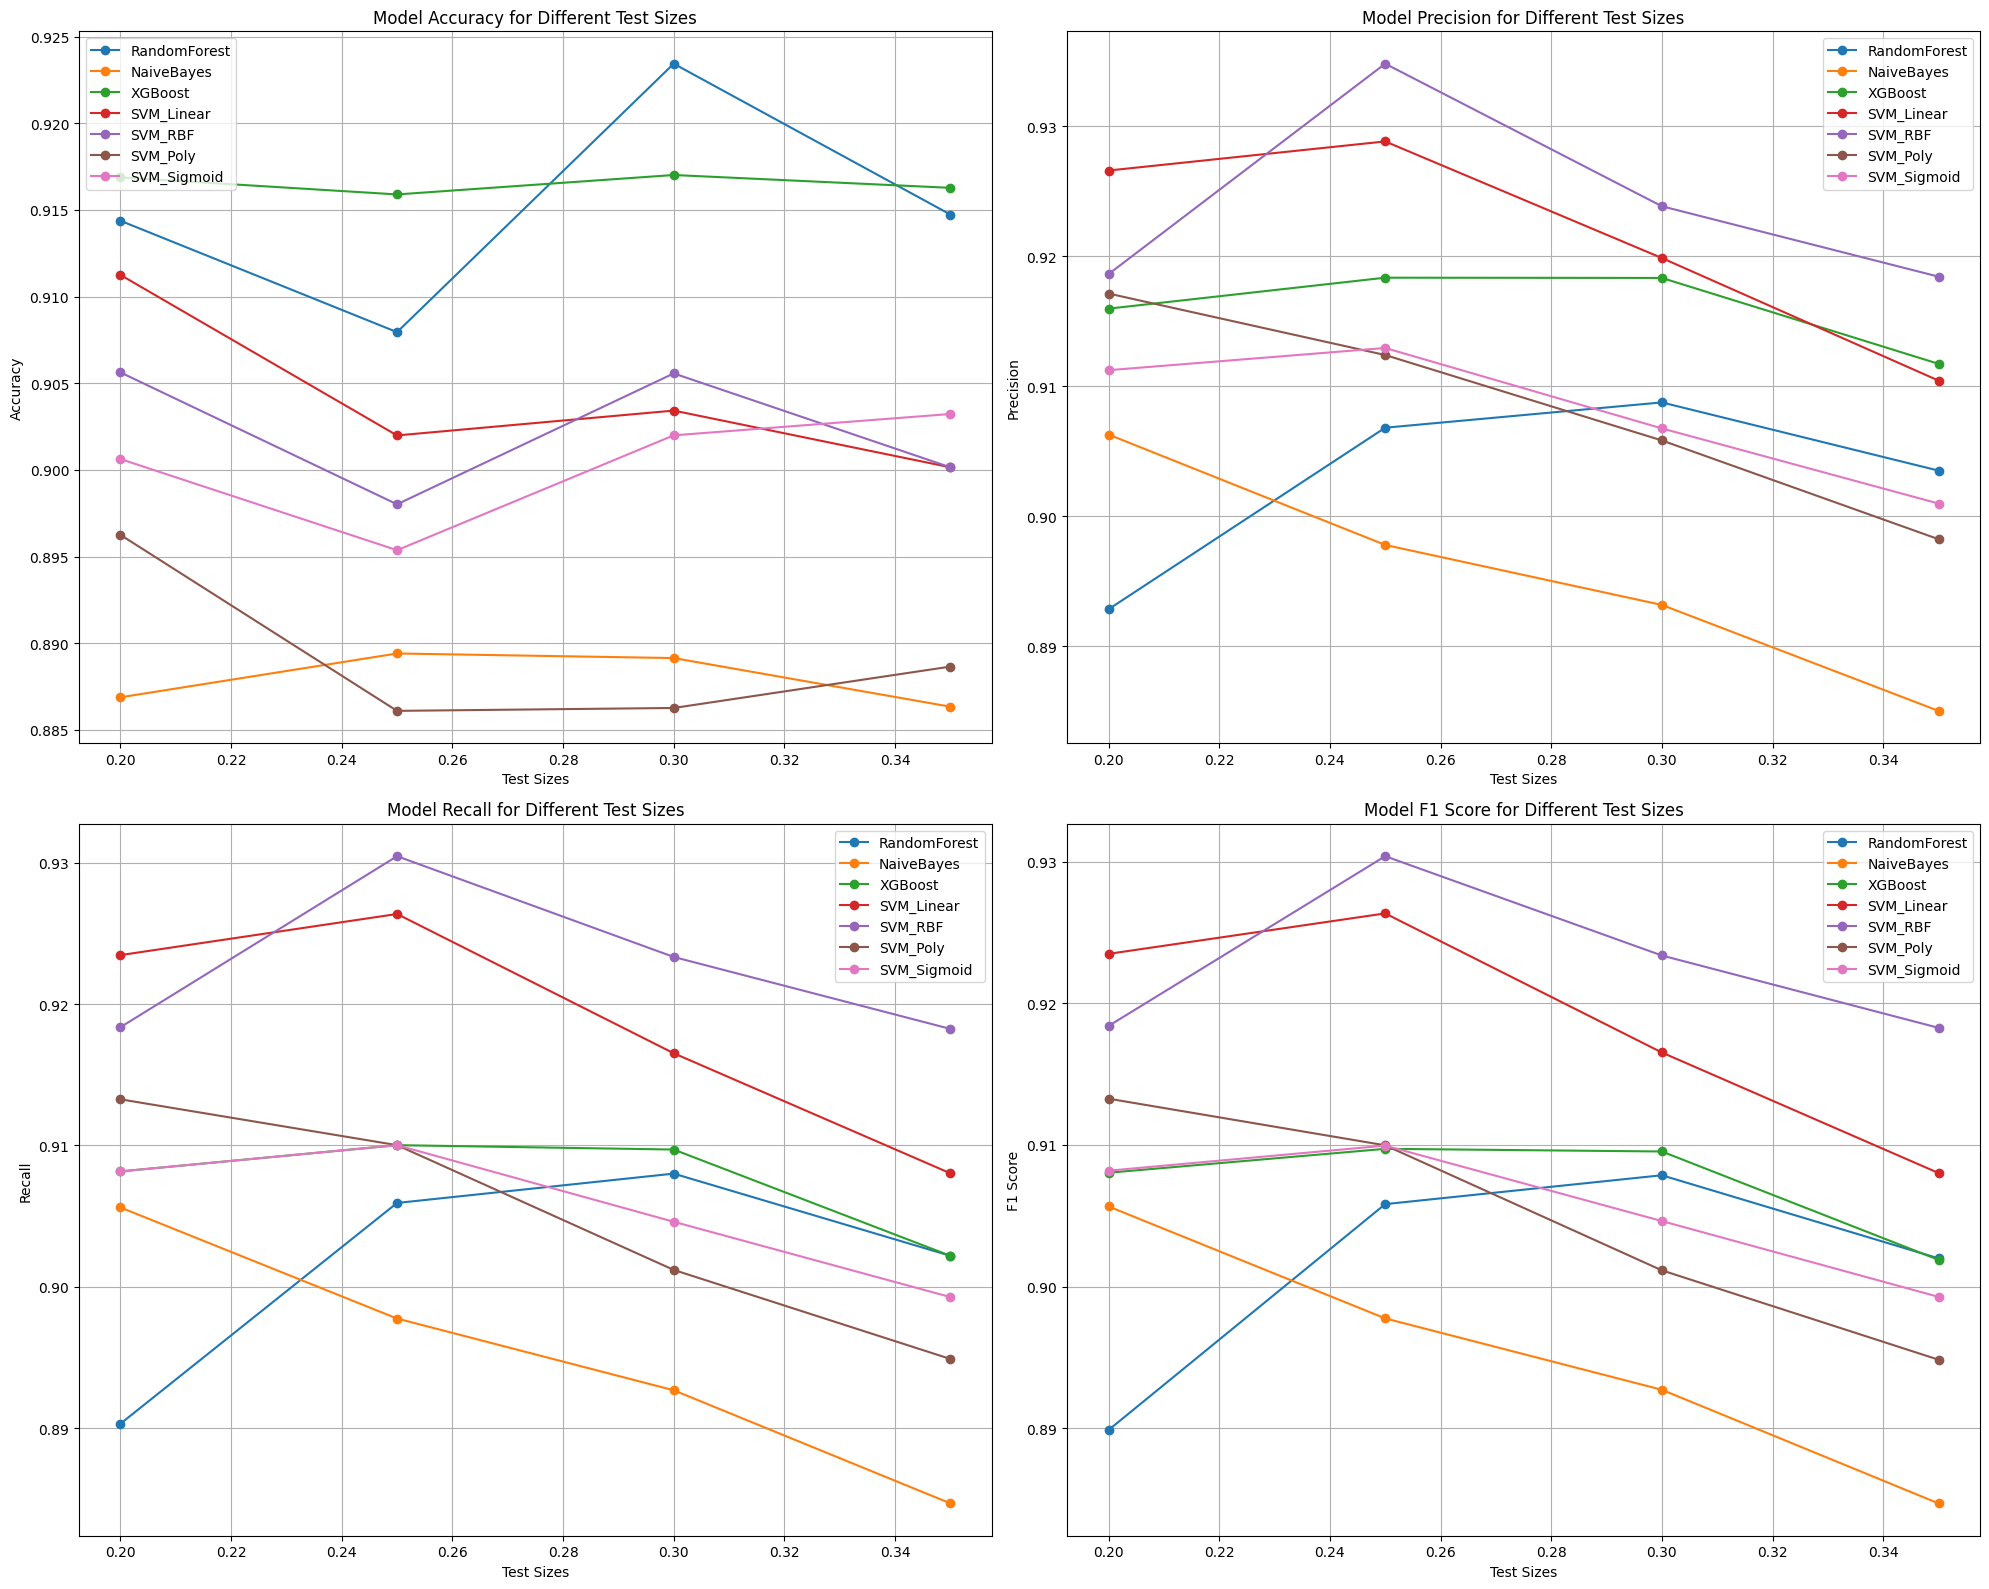

In [75]:

# Visualization of evaluation metrics for each model
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
plt.figure(figsize=(20, 16))

for idx, metric in enumerate(metrics):
    plt.subplot(2, 2, idx + 1)
    for model_name in results_df['Model'].unique():
        model_results = results_df[results_df['Model'] == model_name]
        plt.plot(model_results['Test Size'], model_results[metric], marker='o', label=model_name)
    
    plt.xlabel('Test Sizes')
    plt.ylabel(metric)
    plt.title(f'Model {metric} for Different Test Sizes')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()


<Figure size 1400x1000 with 0 Axes>

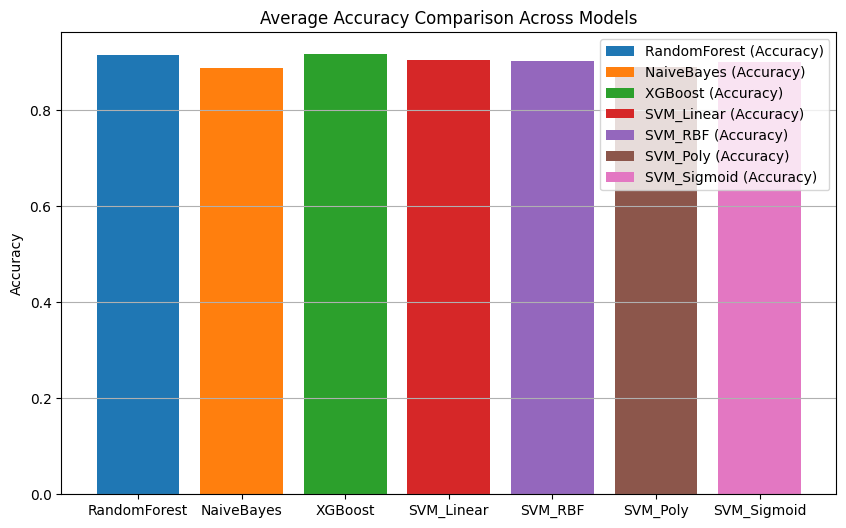

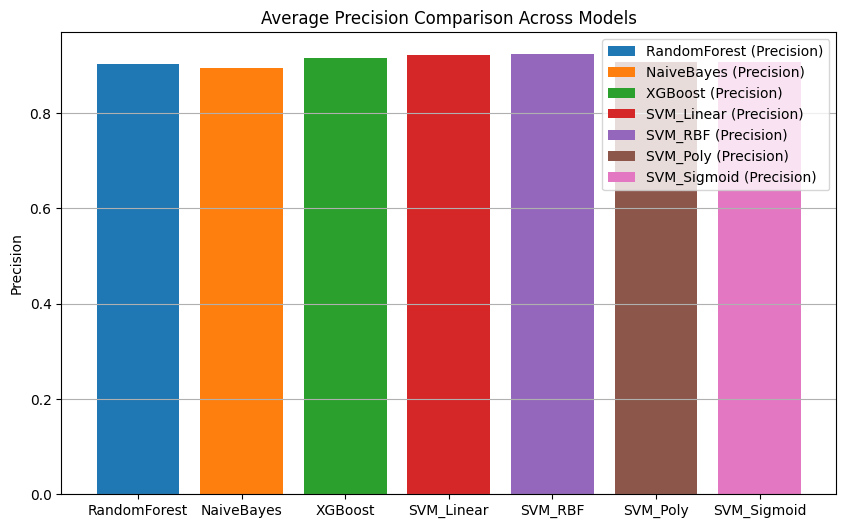

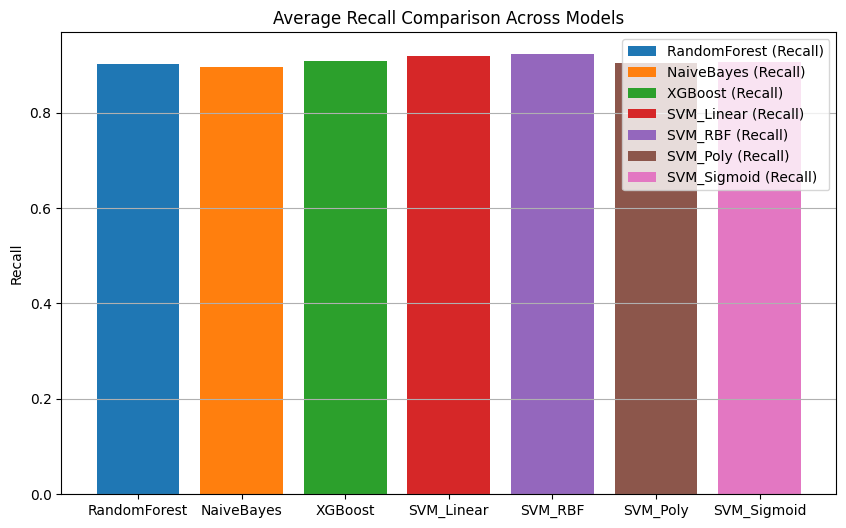

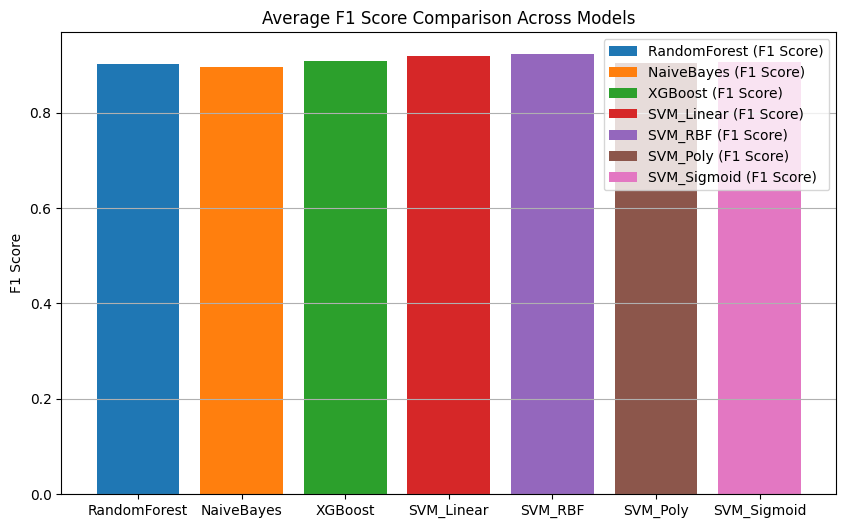

In [76]:
# Metrics comparison for each model
comparison_metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
plt.figure(figsize=(14, 10))

for metric in comparison_metrics:
    plt.figure(figsize=(10, 6))
    for model_name in results_df['Model'].unique():
        model_results = results_df[results_df['Model'] == model_name]
        avg_metric_value = model_results[metric].mean()
        plt.bar(model_name, avg_metric_value, label=f'{model_name} ({metric})')
    
    plt.ylabel(metric)
    plt.title(f'Average {metric} Comparison Across Models')
    plt.legend()
    plt.grid(axis='y')
    plt.show()


<Figure size 1400x1000 with 0 Axes>

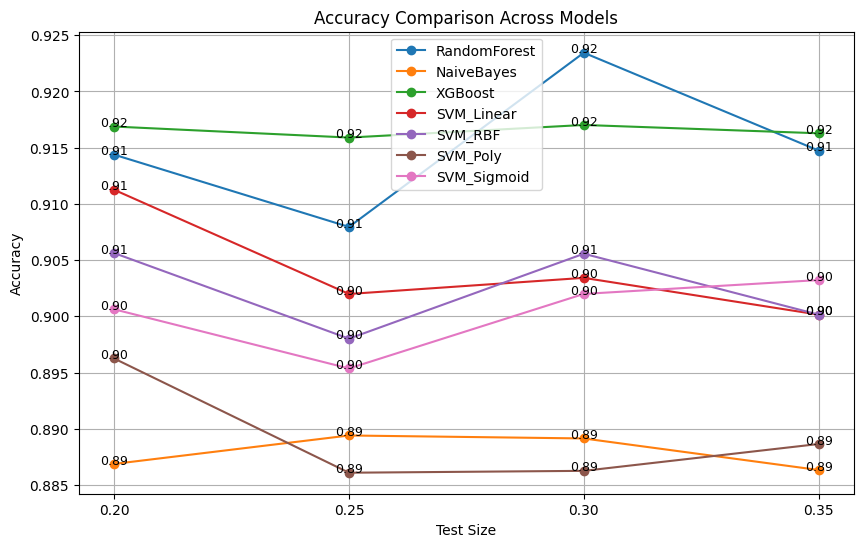

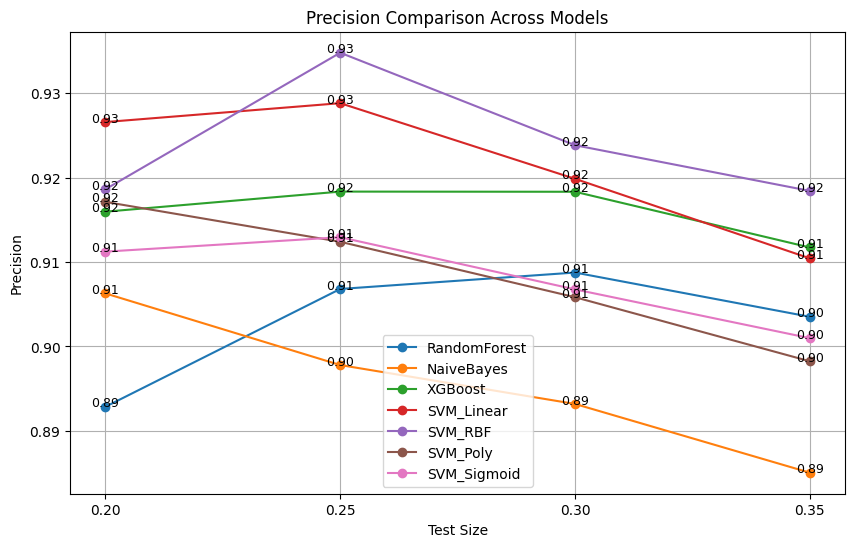

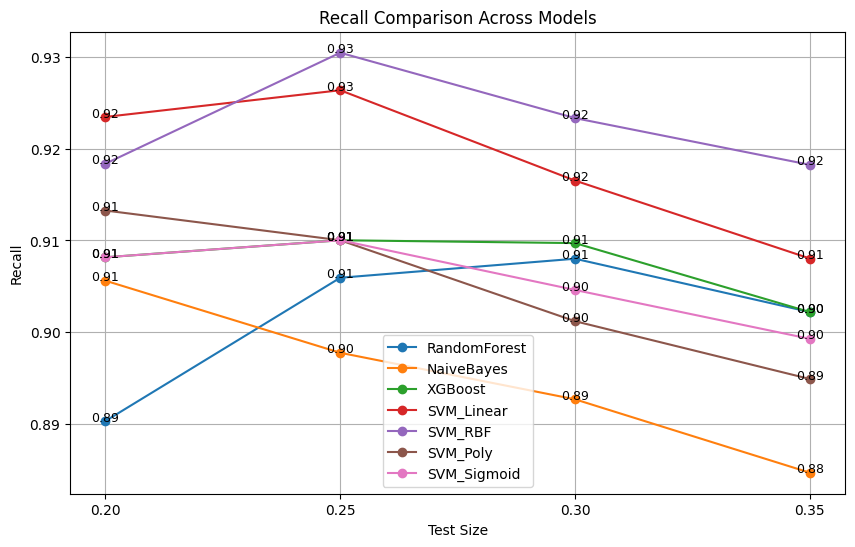

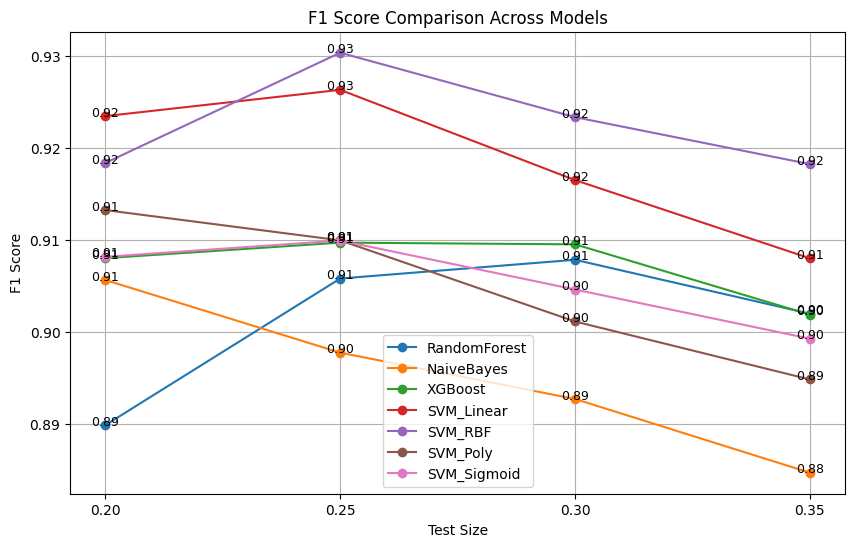

In [77]:
# Metrics comparison for each model
comparison_metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
plt.figure(figsize=(14, 10))

for metric in comparison_metrics:
    plt.figure(figsize=(10, 6))
    for model_name in results_df['Model'].unique():
        model_results = results_df[results_df['Model'] == model_name]
        plt.plot(model_results['Test Size'], model_results[metric], marker='o', label=model_name)
        for x, y in zip(model_results['Test Size'], model_results[metric]):
            plt.text(x, y, f'{y:.2f}', fontsize=9, ha='center')
    
    plt.xlabel('Test Size')
    plt.xticks(test_sizes)  # Show only 0.2, 0.25, 0.3, 0.35 on x-axis
    plt.ylabel(metric)
    plt.title(f'{metric} Comparison Across Models')
    plt.legend()
    plt.grid()
    plt.show()

